This is for Chapter 12 and Week 7 homework from [Winter 2020 of Statistical Rethinking](https://github.com/rmcelreath/stat_rethinking_2020/tree/main/homework) using Python. A public repo using `pmyc3` has been created [here](https://github.com/pymc-devs/resources/tree/master/Rethinking_2) that also uses Python.

Note that this notebook includes code for the "censored cats" discussion that was in the lecture but did not make the final, second edition section of the book. However, there's [tidyverse code](https://bookdown.org/content/4857/god-spiked-the-integers.html#bonus-survival-analysis) for this section on survival analysis. The Bayes discourse group also helped me. Thanks to Rojan for sharing his pymc code and Nathaniel for sending me pages of this section that were in a draft version of the book.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
from scipy.special import expit as logistic
import daft
from causalgraphicalmodels import CausalGraphicalModel

from scipy.optimize import curve_fit

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [3]:
sns.set_context("talk")

<IPython.core.display.Javascript object>

In [6]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

# Censored cats and survival analysis

These concepts were covered in lecture 13 [here](https://youtu.be/p7g-CgGCS34?list=PLDcUM9US4XdNM4Edgs7weiyIguLSToZRI&t=1433). I used the R `rethinking` package to obtain the data. The question is to determine whether black cats are more discriminated against for adoption than other cats.


In [9]:
df_cats = pd.read_csv("other_data/AustinCats.csv", sep=",")
df_cats.head()

,id,days_to_event,date_out,out_event,date_in,in_event,breed,color,intake_age
0,A730601,1,07/08/2016 09:00:00 AM,Transfer,07/07/2016 12:11:00 PM,Stray,Domestic Shorthair Mix,Blue Tabby,7
1,A679549,25,06/16/2014 01:54:00 PM,Transfer,05/22/2014 03:43:00 PM,Stray,Domestic Shorthair Mix,Black/White,1
2,A683656,4,07/17/2014 04:57:00 PM,Adoption,07/13/2014 01:20:00 PM,Stray,Snowshoe Mix,Lynx Point,2
3,A709749,41,09/22/2015 12:49:00 PM,Transfer,08/12/2015 06:29:00 PM,Stray,Domestic Shorthair Mix,Calico,12
4,A733551,9,09/01/2016 12:00:00 AM,Transfer,08/23/2016 02:35:00 PM,Stray,Domestic Shorthair Mix,Brown Tabby/White,1


<IPython.core.display.Javascript object>

In [12]:
df_cats.shape

(22356, 11)

<IPython.core.display.Javascript object>

Prepare dataframe as described in the lecture.

In [15]:
# Getting adopted is 1
df_cats["adopt"] = np.where(df_cats["out_event"] == "Adoption", 1, 0)

# It looks like he used black as lower index
df_cats["color_id"] = np.where(df_cats["color"] == "Black", 0, 1)

df_cats.head(10)

,id,days_to_event,date_out,out_event,date_in,in_event,breed,color,intake_age,adopt,color_id,color_id
0,A730601,1,07/08/2016 09:00:00 AM,Transfer,07/07/2016 12:11:00 PM,Stray,Domestic Shorthair Mix,Blue Tabby,7,0,1,1
1,A679549,25,06/16/2014 01:54:00 PM,Transfer,05/22/2014 03:43:00 PM,Stray,Domestic Shorthair Mix,Black/White,1,0,1,1
2,A683656,4,07/17/2014 04:57:00 PM,Adoption,07/13/2014 01:20:00 PM,Stray,Snowshoe Mix,Lynx Point,2,1,1,1
3,A709749,41,09/22/2015 12:49:00 PM,Transfer,08/12/2015 06:29:00 PM,Stray,Domestic Shorthair Mix,Calico,12,0,1,1
4,A733551,9,09/01/2016 12:00:00 AM,Transfer,08/23/2016 02:35:00 PM,Stray,Domestic Shorthair Mix,Brown Tabby/White,1,0,1,1
5,A756485,4,08/24/2017 05:34:00 PM,Adoption,08/20/2017 03:07:00 PM,Stray,Domestic Shorthair Mix,Blue Tabby,1,1,1,1
6,A732960,4,08/19/2016 06:27:00 PM,Adoption,08/15/2016 03:08:00 PM,Stray,Domestic Shorthair Mix,Calico,2,1,1,1
7,A664571,5,10/10/2013 02:07:00 PM,Adoption,10/05/2013 01:43:00 PM,Owner Surrender,Domestic Shorthair Mix,Torbie,24,1,1,1
8,A727402,24,06/14/2016 04:18:00 PM,Adoption,05/21/2016 04:30:00 PM,Stray,Domestic Shorthair Mix,Brown Tabby,1,1,1,1
9,A749579,2,05/18/2017 03:36:00 PM,Transfer,05/16/2017 05:19:00 PM,Stray,Domestic Shorthair Mix,Blue Tabby,3,0,1,1


<IPython.core.display.Javascript object>

In [17]:
df_cats["color_id"].value_counts()

1    19391
0     2965
Name: color_id, dtype: int64

<IPython.core.display.Javascript object>

Rojan's code

```
def likelihood(lam,obs_value,censored):
    return (censored*tt.log(lam) - lam * obs_value)

with pm.Model() as m_1:
   cid=pm.Data('cid',df['black'])
    adopted=pm.intX(pm.Data('adopted',df['adopted']))
    a=pm.Normal('a',0,1,shape=2)
    mu = pm.math.exp(a[cid])
    lam= pm.Deterministic('lam',1/mu)
 D=pm.Potential('D',likelihood(lam=lam,obs_value=df['days_to_event'].values,censored=adopted))
  trace_1=pm.sample()

```

In [18]:
def likelihood(lam, obs_value, censored):
    return censored * tt.log(lam) - lam * obs_value

<IPython.core.display.Javascript object>

In [20]:
with pm.Model() as m_cats1:
    # priors
    a = pm.Normal("a", 0, 1, shape=2)

    mu = pm.math.exp(a[df_cats["color_id"]])
    lam = pm.Deterministic("lam", 1 / mu)

    D = pm.Potential(
        "D",
        likelihood(
            lam=lam,
            obs_value=df_cats["days_to_event"].values,
            censored=df_cats["adopt"],
        ),
    )

    trace_1 = pm.sample(1000, tune=1000, return_inferencedata=True)

NameError: name 'tt' is not defined

<IPython.core.display.Javascript object>

# Question 1 (12H7)

In the Trolley data—`data(Trolley)`—we saw how education level (modeled as an ordered category) is associated with responses. Is this association causal? One plausible confound is that education is also associated with age, through a causal process: People are older when they finish school than when they begin it.

Reconsider the Trolley data in this light. Draw a DAG that represents hypothetical causal relationships among response, education, and age. Which statical model or models do you need to evaluate the causal influence of education on responses? Fit these models to the trolley data. What do you conclude about the causal relationships among these three variables?

## Data exploration and setup

In [24]:
df_trolley = pd.read_csv(
    "../pymc3_ed_resources/resources/Rethinking_2/Data/Trolley.csv",
    delimiter=";",
)
df_trolley.head()

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1


<IPython.core.display.Javascript object>

In [25]:
print("shape of df: ", df_trolley.shape)

shape of df:  (9930, 12)


<IPython.core.display.Javascript object>

## DAG

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


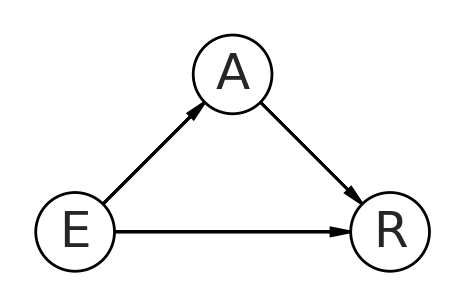

<IPython.core.display.Javascript object>

In [28]:
pipe_dag = CausalGraphicalModel(
    nodes=["E", "A", "R"],
    edges=[
        ("E", "A"),
        ("A", "R"),
        ("E", "R"),
    ],
)
pgm = daft.PGM()

coordinates = {
    "E": (0, 0),
    "A": (1, 1),
    "R": (2, 0),
}
for node in pipe_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in pipe_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()


## Naive approach

Before even tackling the DAG, I wanted to contrast it with what I would've done if I were naive to the methods of this chapter (or even the whole book). Here is how I'd approach it. I suppose I'd simply do a comparison of each department for gender.

In [9]:
df_grants["prop_awarded"] = df_grants["awards"] / df_grants["applications"]
df_grants.head()

,discipline,gender,applications,awards,prop_awarded
0,Chemical sciences,m,83,22,0.265060
1,Chemical sciences,f,39,10,0.256410
2,Physical sciences,m,135,26,0.192593
3,Physical sciences,f,39,9,0.230769
4,Physics,m,67,18,0.268657


<IPython.core.display.Javascript object>

Then I suppose I'd do like a difference in proportions test, like shown at the bottom of [this statsmodels z-test page](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html).

In [10]:
from statsmodels.stats.proportion import proportions_ztest

ztest_pval = list()
count_list = np.array(df_grants['awards'])
nobs_list = np.array(df_grants['applications'])
for i in range(0, len(df_grants), 2):
    #print(i)
    stat, pval = proportions_ztest(df_grants.loc[i : i + 1, "awards"], df_grants.loc[i:i+1, 'applications'])
    ztest_pval.append(pval)
    if df_grants.loc[i, "prop_awarded"] > df_grants.loc[i + 1, "prop_awarded"]:
        higher_gender = "M"
    else:
        higher_gender = 'F'
    print(df_grants.loc[i, "discipline"], '{0:0.3f}'.format(pval), higher_gender)
    


Chemical sciences 0.919 M
Physical sciences 0.600 F
Physics 0.766 M
Humanities 0.191 F
Technical sciences 0.356 F
Interdisciplinary 0.058 F
Earth/life sciences 0.035 M
Social sciences 0.107 M
Medical sciences 0.016 M


<IPython.core.display.Javascript object>

I might conclude that "Medical sciences" and "Interdisciplinary" have evidence of bias, but this would be unsatisfying of course. For one, I have ignored the raw counts (number of applications and awards). Intuitively, a higher n would give more confidence in the proportion. Now I can go deeper with the GLM tools I've learned in these chapters.

# Following template

## Model equation

## Simulate

## Prior predictions

## Generate posterior

## Evaluate chain and posterior

## Posterior predictions

## Summary statement

# Principled approach and seeing how entropy applies

Essentially, this is how we know the counts and have observed values for the number of awards.

[PSU Stat explanation](https://online.stat.psu.edu/stat504/lesson/6/6.1)

This took me a long time to wrap my head around... but the key is going back to one of the early lessons and thinking about model strategy. Think about what's known, unknown, what's the generative process, and think about what you're trying to find out.

Here, we're ultimately trying to find p.    

## Generalized linear model

The structure of the generalized linear model with a binomial likelihood is something like this:

$$y_i ∼ \text{Binomial}(n, pi) \tag{likelihood}$$
<br>
$$  f(p_i) = \text{logit}(p_i) = \alpha + \beta x_i \tag{link function}$$    

The **logit link** function can be expanded as the logit is defined as log-odds:

$$  \text{logit}(p_i) = \text{log}\frac{p_i}{1-p_i} \tag{link function}$$


We can then simply solve for \(p_i\):

$$  p_i = \frac{\text{exp}(\alpha + \beta x_i)}{1 + \text{exp}(\alpha + \beta x_i)} \tag{logistic or inverse-logit}$$

Here are some useful snippets from the book that resonated with me:

> A unit change in xi may produce a larger or smaller change in the probability pi, depending upon how far from zero the log-odds are.
<br>
...The key lesson for now is just that no regression coefficient, such as β, from a GLM ever produces a constant change on the outcome scale.
...Recall that we defined interaction (Chapter 8) as a situation in which the effect of a predictor depends upon the value of another predictor. Well now every predictor essentially interacts with itself, because the impact of a change in a predictor depends upon the value of the predictor before the change. More generally, every predictor variable effectively interacts with every other predictor variable, whether you explicitly model them as interactions or not. This fact makes the visualization of counter-factual predictions even more important for understanding what the model is telling you.

**When looking at the original problem, a question that occurred to me is: How is it that we're ultimately interested in proportions but the likelihood, which is a binomial distribution, has an x-axis of counts?**

As a result of starting with my naive approach, where my intuition was to calculate the proportions awarded for each gender, one of the insights I had just now is that the proportion in our GLM is not the outcome variable of the first likelihood function (which is a binominal distribution resulting in counts). Rather it is in the second likelihood function, the link function. The predictive plots in the book's examples all show proportions as the unit of interest, which makes sense. So how is it that we're modeling counts? (Why do we use  binomial rather than something like beta which does proportions as an outcome variable? I'm not sure.)

Here are some thoughts that occurred to me as I attempted to answer my own question:
1. Even if we were to use a beta distribution, we do not have the actual counts for successes/failures or total. In this example, it would be the number of awarded grants and total applications. The binomial distribution includes this information.
2. The observed data are counts. This approach at least satisfies one of the weaknesses I had in my naive approach (just doing a z-test of proportions).
3. The parameter $p_i$ is unknown and unobserved. It reminded me of [this slide](https://youtu.be/XoVtOAN0htU?list=PLDcUM9US4XdNM4Edgs7weiyIguLSToZRI&t=1422) in one of the first lectures, listing observed and unobserved variables and describing the generative relations as part of the construction perspective.

Other thoughts:
- Even if we "push things through the GLM" to make predictions, it still seems like proportions are what we evaluate and not counts, which is at the end of the predictive engine.

Let's proceed with the problem solving template that the book lays out, but we will come back to this.

## Counts vs. probability in likelihood

After asking the Discord channel and thinking things through, I'm beginning to understand a little bit more the role of the likelihood....but still have to think about it a lot.

I have to remember the definition of likelihood: it is the relative plausibility of an observation. The counts in this example are observed, hence the logic of using binomial.

In previous examples that were using Gaussian distribution, the units of the likelihood matched the units of our desired predictions.

Keep moving forward.

## Setting up the problem, gender term only

This setup and code was modeled on R code 11.29 from the book and also from the pymc repo.

Let's start first with a simple GLM that only focuses on gender. We have an aggregated binomial data structure and therefore the model looks like this:

$$ A_i \sim \text{Binomial}(N_i, p_i) $$
$$ \text{logit}(p_i) = \alpha_{GID[i]} $$
$$ \alpha_j \sim \text{Normal}(0, 1.5) $$    

We first need to create index variables. We'll use `pd.Categorical`.

In [35]:
# Used categories argument to specify m as 0 and f as 1 per the book (1 and 2, respectively in R code)
df_grants["gender_code"] = pd.Categorical(
    df_grants["gender"], categories=["m", "f"]
).codes

<IPython.core.display.Javascript object>

Our dataframe now looks like this. Note that males are designated as 0 and females as 1.

In [36]:
df_grants.head()

,discipline,gender,applications,awards,prop_awarded,discipline_code,gender_code
0,Chemical sciences,m,83,22,0.265060,0,0
1,Chemical sciences,f,39,10,0.256410,0,1
2,Physical sciences,m,135,26,0.192593,5,0
3,Physical sciences,f,39,9,0.230769,5,1
4,Physics,m,67,18,0.268657,6,0


<IPython.core.display.Javascript object>

In [280]:
glm1

<IPython.core.display.Javascript object>

In [37]:
with pm.Model() as glm1:
    #  Prior for the alpha term
    # a = pm.Normal("a", 0, 1.5, shape=2)   # My choice from UCB example
    # Changed due to solutions (from domain knowledge that less than half of applicants get awards)
    a = pm.Normal("a", -1, 1, shape=2)

    # The link function
    # Note difference from R code: logit(p) <- a[gid]
    p = pm.Deterministic("p", pm.math.invlogit(a[df_grants["gender_code"]]))

    # Likelihood
    award = pm.Binomial(
        "award", p=p, n=df_grants["applications"], observed=df_grants["awards"]
    )

    trace_glm1 = pm.sample(
        1000, tune=1000, return_inferencedata=True
    )  # used arguments I've used before

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


<IPython.core.display.Javascript object>

In [40]:
az.summary(trace_glm1, var_names=["a"], round_to=3)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.533,0.065,-1.640,-1.431,0.001,0.001,3461.71,3461.710,3468.345,2876.233,1.000
a[1],-1.740,0.081,-1.861,-1.609,0.001,0.001,3294.33,3291.245,3295.279,2940.342,1.001


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

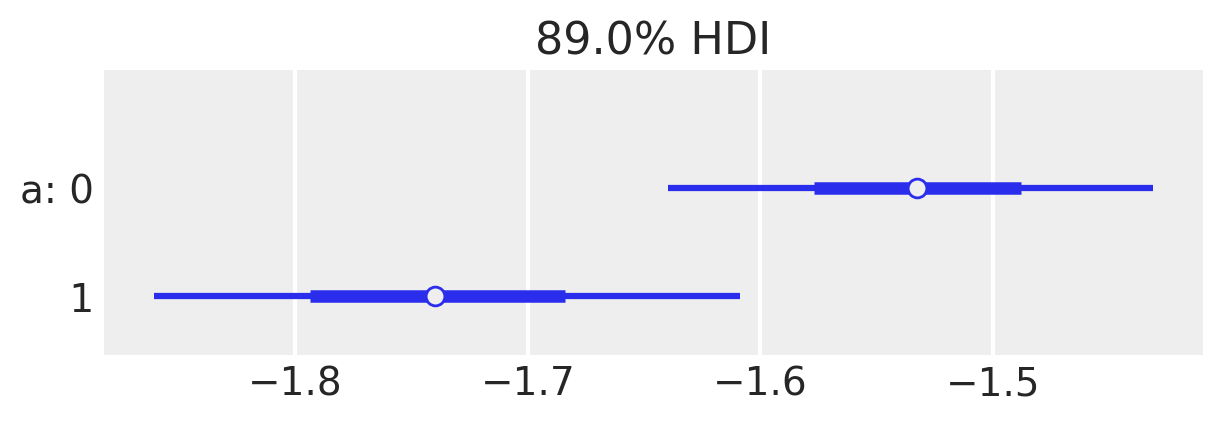

<IPython.core.display.Javascript object>

In [42]:
f, ax1 = plt.subplots(figsize=(6, 2))
az.plot_forest(trace_glm1, var_names=["a"], combined=True, ax=ax1)

### Interpreting differences

The posterior for male applicants trends higher than females although there is some overlap. Compute the contrast to get a better sense. Calculate contrasts on both the logit (relative) and outcome (absolute) scales.

In [43]:
# Take a look at the trace object
trace_glm1_df = trace_glm1.to_dataframe()
trace_glm1_df.head()

,chain,draw,"(posterior, a[0], 0)","(posterior, a[1], 1)","(posterior, p[0], 0)","(posterior, p[10], 10)","(posterior, p[11], 11)","(posterior, p[12], 12)","(posterior, p[13], 13)","(posterior, p[14], 14)",...,"(sample_stats, perf_counter_start)","(sample_stats, max_energy_error)","(sample_stats, depth)","(sample_stats, energy_error)","(sample_stats, diverging)","(sample_stats, energy)","(sample_stats, lp)","(sample_stats, step_size)","(sample_stats, tree_size)","(sample_stats, step_size_bar)"
0,0,0,-1.537064,-1.664010,0.176962,0.176962,0.159224,0.176962,0.159224,0.176962,...,768.601701,0.124197,1,0.124197,False,63.842621,-63.802686,1.417925,1.0,1.146981
1,0,1,-1.562078,-1.851493,0.173349,0.173349,0.135698,0.173349,0.135698,0.173349,...,768.602258,0.259713,2,0.259713,False,64.633434,-64.447520,1.417925,3.0,1.146981
2,0,2,-1.560664,-1.622147,0.173551,0.173551,0.164909,0.173551,0.164909,0.173551,...,768.602911,-0.186713,2,0.047203,False,65.099080,-64.520118,1.417925,3.0,1.146981
3,0,3,-1.466389,-1.718039,0.187492,0.187492,0.152124,0.187492,0.152124,0.187492,...,768.603459,-0.286899,2,-0.286899,False,64.713004,-63.933655,1.417925,3.0,1.146981
4,0,4,-1.466081,-1.739567,0.187539,0.187539,0.149368,0.187539,0.149368,0.187539,...,768.604005,-0.154756,2,-0.010150,False,64.114738,-63.909488,1.417925,3.0,1.146981


<IPython.core.display.Javascript object>

In [44]:
# Also interesting to see log-likelihood as one of the columns
# trace_glm1_df.columns

<IPython.core.display.Javascript object>

In [62]:
# a extracts from the posterior directly
diff_a = (
    trace_glm1_df[("posterior", "a[0]", 0)] - trace_glm1_df[("posterior", "a[1]", 1)]
)

<IPython.core.display.Javascript object>

Since we had built the model using logit p, we would have to do inverse logit (AKA logistic) on the parameter to get p back and calculate on the absolute scale. We'll use the scipy function.

In [63]:
# ?logistic

<IPython.core.display.Javascript object>

In [64]:
diff_p = logistic(trace_glm1_df[("posterior", "a[0]", 0)]) - logistic(
    trace_glm1_df[("posterior", "a[1]", 1)]
)

<IPython.core.display.Javascript object>

In [66]:
az.summary({"diff_p": diff_p, "diff_a": diff_a}, kind="stats", round_to=3)

,mean,sd,hdi_5.5%,hdi_94.5%
diff_p,0.028,0.014,0.005,0.050
diff_a,0.207,0.104,0.049,0.378


<IPython.core.display.Javascript object>

### More about effect sizes

From McElreath:
<br>
"...Absolute effects [are] the difference a counter-factual change in a variable might make on an absolute scale of measurement, like the probability of an event... It is more common to see logistic regressions interpreted through relative effects. Relative effects are proportional changes in the odds of an outcome. If we change a variable and say the odds of an outcome double, then we are discussing relative effects. You can calculate these proportional odds relative effect sizes by simply exponentiating the parameter of interest.

**double-check this**

In [53]:
prop_odds = np.mean(np.exp(diff_a))
print("Proportional odds: {0:0.3f}".format(prop_odds))

Proportional odds: 1.237


<IPython.core.display.Javascript object>

| Scale of effect | parameter | variable  |  value here |
| --- | --- | ---|  --- |
| absolute | outcome | diff_p |  0.028 |
| relative | logit (log-odds?) | diff_a |  0.207  |
| relative | proportional odds | exp(diff_a) |  1.237 |

Here `diff_a` is the log-odds difference. It is positive (although the lower bound is barely above 0), indicating that there's a higher probability of admission for male applicants.

With regards to the last line of the table, this means that switching gender would yield about a 24% increase in odds of being awarded..

## Direct influence of gender, conditioning on discipline

Returning to the DAG, we would need to close the backdoor by conditioning on discipline to find the direct influence of gender.

In [55]:
# Used categories argument to specify m as 0 and f as 1 per the book (1 and 2, respectively in R code)
df_grants["discipline_code"] = pd.Categorical(df_grants["discipline"]).codes

<IPython.core.display.Javascript object>

In [56]:
df_grants.head()

,discipline,gender,applications,awards,prop_awarded,discipline_code,gender_code
0,Chemical sciences,m,83,22,0.265060,0,0
1,Chemical sciences,f,39,10,0.256410,0,1
2,Physical sciences,m,135,26,0.192593,5,0
3,Physical sciences,f,39,9,0.230769,5,1
4,Physics,m,67,18,0.268657,6,0


<IPython.core.display.Javascript object>

In [57]:
df_grants["discipline_code"].unique()

array([0, 5, 6, 2, 8, 3, 1, 7, 4], dtype=int8)

<IPython.core.display.Javascript object>

In [19]:
with pm.Model() as glm2:
    #  Prior for the alpha and delta terms
    a = pm.Normal("a", -1, 1, shape=2)
    d = pm.Normal("d", 0, 1.5, shape=9)

    # The link function
    # Note difference from R code: logit(p) <- a[gid]
    p = pm.Deterministic(
        "p",
        pm.math.invlogit(a[df_grants["gender_code"]] + d[df_grants["discipline_code"]]),
    )

    # Likelihood
    award = pm.Binomial(
        "award", p=p, n=df_grants["applications"], observed=df_grants["awards"]
    )

    trace_glm2 = pm.sample(
        1000, tune=1000, return_inferencedata=True
    )  # used arguments I've used before

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The number of effective samples is smaller than 10% for some parameters.


<IPython.core.display.Javascript object>

Note from solutions: "Those chains didn’t sample very efficiently. This is because the model is over-parameterized—it has more parameters than absolutely necessary. This doesn’t break it. It just makes
the sampling less efficient."

In [258]:
az.summary(trace_glm2, var_names=["a", "d"], round_to=3)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.260,0.433,-1.985,-0.588,0.023,0.017,356.412,321.648,355.657,372.076,1.010
a[1],-1.402,0.434,-2.049,-0.653,0.023,0.017,369.448,337.019,369.473,393.786,1.010
d[0],0.256,0.471,-0.533,0.989,0.023,0.018,416.658,340.141,414.567,453.138,1.009
d[1],-0.080,0.453,-0.792,0.647,0.023,0.016,395.034,395.034,395.636,445.566,1.009
d[2],-0.314,0.449,-1.031,0.409,0.023,0.016,391.310,391.310,389.573,443.101,1.010
d[3],-0.361,0.472,-1.162,0.329,0.023,0.016,412.258,412.258,414.107,509.913,1.011
d[4],-0.416,0.444,-1.138,0.278,0.023,0.016,384.660,384.660,384.594,436.365,1.010
d[5],-0.099,0.465,-0.800,0.686,0.023,0.016,423.728,423.728,421.514,459.758,1.008
d[6],0.227,0.503,-0.601,0.999,0.024,0.018,437.778,413.065,437.600,590.560,1.009
d[7],-0.536,0.441,-1.209,0.210,0.023,0.016,381.198,381.198,380.644,390.792,1.009


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

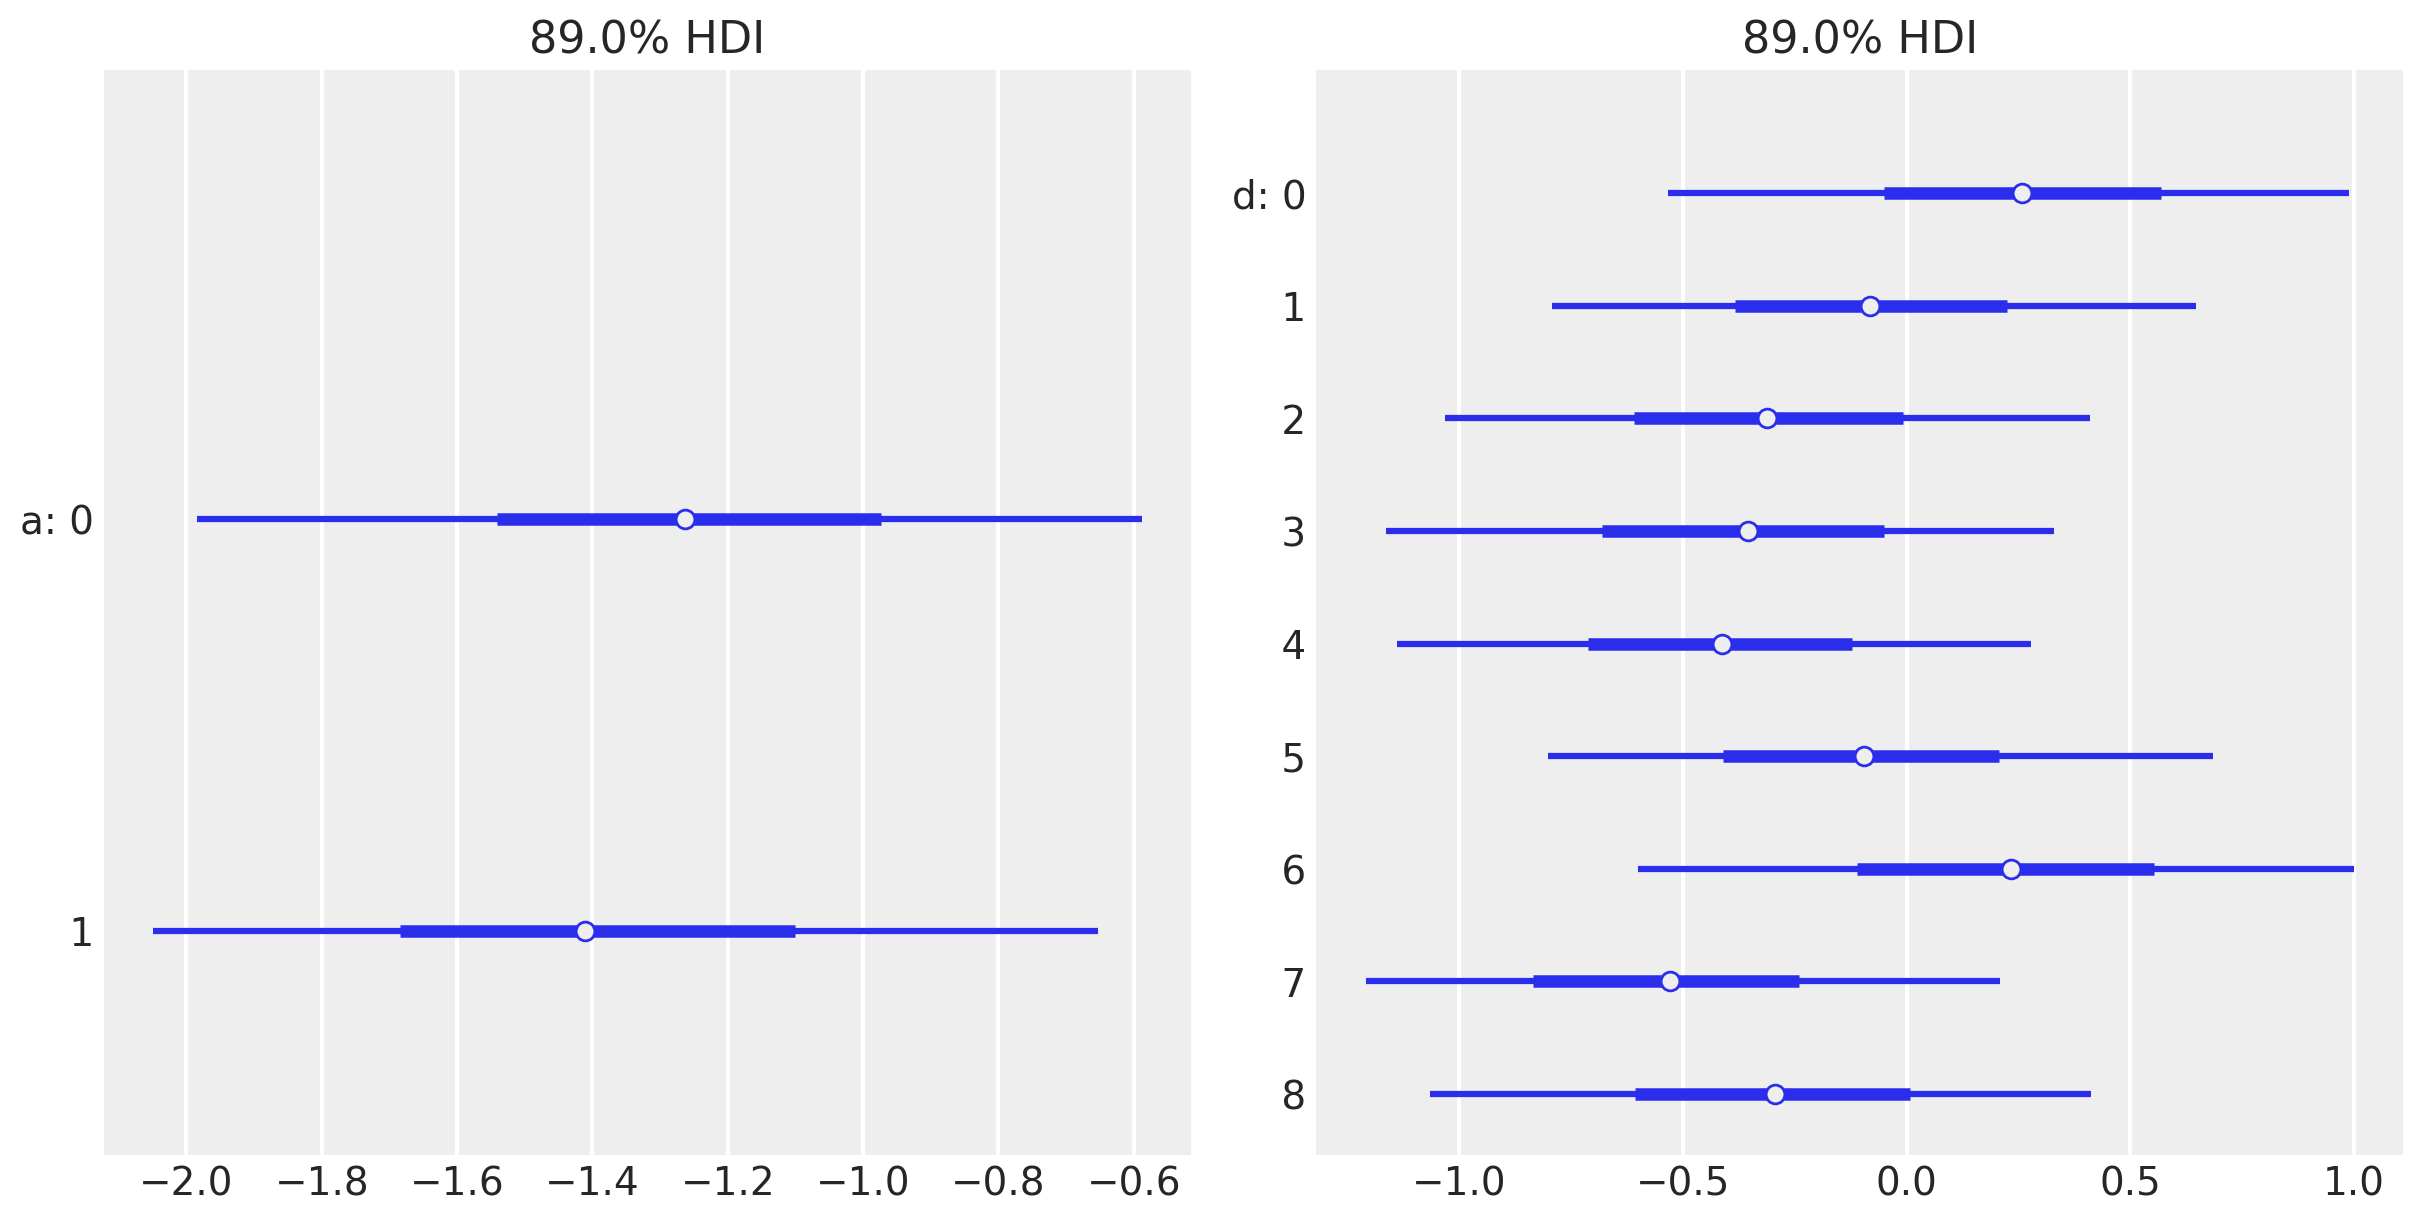

<IPython.core.display.Javascript object>

In [27]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
az.plot_forest(trace_glm2, var_names=["a"], combined=True, ax=ax1)
az.plot_forest(trace_glm2, var_names=["d"], combined=True, ax=ax2)

For the gender, shown on the left, we see that the differences between respective log-odds are smaller.

I'm showing the effect of discipline on the right subplot. Most log-odds are negative, but discipline 6 is positive, suggesting that, on average, applications to this discipline are awarded slightly more than 50% of the time. We'll return to this point.

Let's return to interpreting the gender differences and calculate contrasts properly.

### Interpreting differences

In [58]:
# Take a look at the trace object
trace_glm2_df = trace_glm2.to_dataframe()
trace_glm2_df.head()

,chain,draw,"(posterior, a[0], 0)","(posterior, a[1], 1)","(posterior, d[0], 0)","(posterior, d[1], 1)","(posterior, d[2], 2)","(posterior, d[3], 3)","(posterior, d[4], 4)","(posterior, d[5], 5)",...,"(sample_stats, perf_counter_start)","(sample_stats, max_energy_error)","(sample_stats, depth)","(sample_stats, energy_error)","(sample_stats, diverging)","(sample_stats, energy)","(sample_stats, lp)","(sample_stats, step_size)","(sample_stats, tree_size)","(sample_stats, step_size_bar)"
0,0,0,-1.244711,-1.304266,0.225946,-0.219058,-0.233938,-0.386399,-0.572113,-0.162285,...,10.949976,2.915981,3,-0.155245,False,71.000098,-66.443577,0.209726,7.0,0.216338
1,0,1,-2.297566,-2.428387,1.384511,1.092071,0.606298,0.691485,0.630743,0.639928,...,10.951106,0.976167,6,0.063577,False,74.423266,-70.592245,0.209726,47.0,0.216338
2,0,2,-2.254114,-2.343903,1.312178,0.926559,0.690306,0.764693,0.736964,0.755079,...,10.955951,0.515360,3,0.203250,False,75.845221,-70.097851,0.209726,7.0,0.216338
3,0,3,-2.173341,-2.350279,1.528494,0.846605,0.682161,0.760716,0.452235,0.675007,...,10.956840,-0.384688,3,-0.057300,False,74.791527,-71.684805,0.209726,7.0,0.216338
4,0,4,-2.151602,-2.382029,1.425929,0.756727,0.576211,0.722897,0.423929,0.727919,...,10.957710,0.473459,3,0.473459,False,75.701762,-73.223646,0.209726,7.0,0.216338


<IPython.core.display.Javascript object>

In [59]:
# a extracts from the posterior directly
diff_a2 = (
    trace_glm2_df[("posterior", "a[0]", 0)] - trace_glm2_df[("posterior", "a[1]", 1)]
)

<IPython.core.display.Javascript object>

In [60]:
# convert from log-odds to odds
diff_p2 = logistic(trace_glm2_df[("posterior", "a[0]", 0)]) - logistic(
    trace_glm2_df[("posterior", "a[1]", 1)]
)

<IPython.core.display.Javascript object>

In [70]:
az.summary({"diff_p2": diff_p, "diff_a2": diff_a2}, kind="stats", round_to=3)

,mean,sd,hdi_5.5%,hdi_94.5%
diff_p2,0.028,0.014,0.005,0.050
diff_a2,0.142,0.106,-0.028,0.309


<IPython.core.display.Javascript object>

We see that the differences between gender are smaller although there's still a slight edge towards males.

On the absolute scale, males have a 2% advantage. On the relative scale, the odds are 0.139...

### Visualize within each department

Code taken from repo.

In [74]:
df_grants.head()

,discipline,gender,applications,awards,prop_awarded,discipline_code,gender_code
0,Chemical sciences,m,83,22,0.265060,0,0
1,Chemical sciences,f,39,10,0.256410,0,1
2,Physical sciences,m,135,26,0.192593,5,0
3,Physical sciences,f,39,9,0.230769,5,1
4,Physics,m,67,18,0.268657,6,0


<IPython.core.display.Javascript object>

### Predictions

In [303]:
with glm2:
    ppc = pm.sample_posterior_predictive(
        trace_glm2, random_seed=RANDOM_SEED, var_names=["award", "p"]
    )

<IPython.core.display.Javascript object>

In [304]:
ppc

{'award': array([[18,  9, 28, ..., 55, 31, 44],
        [21, 12, 17, ..., 58, 34, 44],
        [22, 11, 25, ..., 53, 34, 34],
        ...,
        [37, 12, 26, ..., 30, 36, 50],
        [31, 14, 35, ..., 53, 33, 35],
        [21, 13, 22, ..., 62, 46, 51]]),
 'p': array([[0.26526811, 0.25382417, 0.19670831, ..., 0.13664613, 0.13981549,
         0.13280544],
        [0.28637491, 0.26040275, 0.16007924, ..., 0.13658481, 0.1588481 ,
         0.14213807],
        [0.28050944, 0.26274977, 0.18256959, ..., 0.13642219, 0.1798816 ,
         0.16701402],
        ...,
        [0.29541875, 0.25752246, 0.17200166, ..., 0.09862884, 0.19121972,
         0.16358666],
        [0.30486334, 0.2482912 , 0.18172517, ..., 0.13178139, 0.1592753 ,
         0.12486641],
        [0.28163589, 0.23727378, 0.17316441, ..., 0.1510227 , 0.19998097,
         0.16551731]])}

<IPython.core.display.Javascript object>

In [306]:
ppc["p"].shape

(4000, 18)

<IPython.core.display.Javascript object>

In [77]:
df_grants["applications"].values[None, :]

array([[ 83,  39, 135,  39,  67,   9, 230, 166, 189,  62, 105,  78, 156,
        126, 425, 409, 245, 260]])

<IPython.core.display.Javascript object>

In [82]:
pp_award = ppc / df_grants["applications"].values[None, :]

<IPython.core.display.Javascript object>

In [123]:
# trace_glm2_df.columns

<IPython.core.display.Javascript object>

In [97]:
pp_award.shape

(4000, 18)

<IPython.core.display.Javascript object>

In [95]:
df_grants.tail()

,discipline,gender,applications,awards,prop_awarded,discipline_code,gender_code
13,Earth/life sciences,f,126,18,0.142857,1,1
14,Social sciences,m,425,65,0.152941,7,0
15,Social sciences,f,409,47,0.114914,7,1
16,Medical sciences,m,245,46,0.187755,4,0
17,Medical sciences,f,260,29,0.111538,4,1


<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


[Text(-2.5, 0, ''),
 Text(0.0, 0, ''),
 Text(2.5, 0, ''),
 Text(5.0, 0, ''),
 Text(7.5, 0, ''),
 Text(10.0, 0, ''),
 Text(12.5, 0, ''),
 Text(15.0, 0, ''),
 Text(17.5, 0, ''),
 Text(20.0, 0, '')]

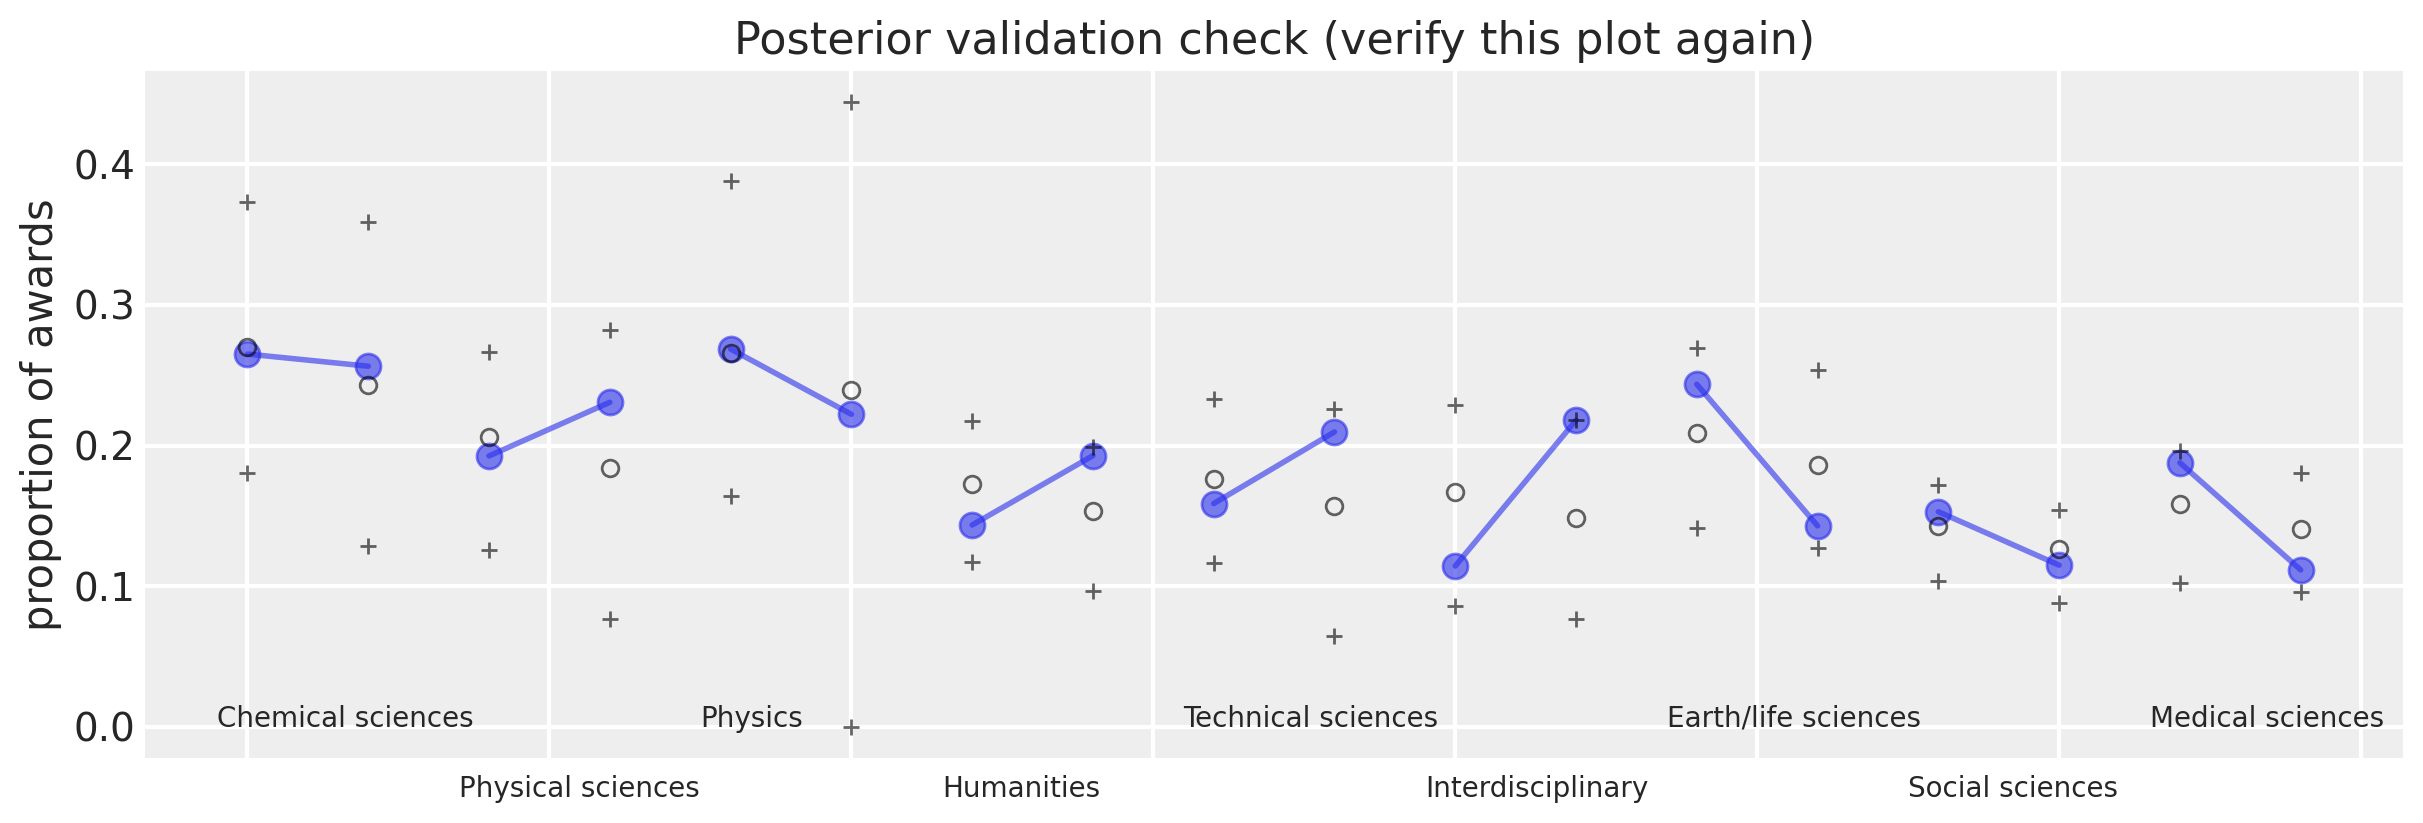

<IPython.core.display.Javascript object>

In [122]:
f, ax1 = plt.subplots(figsize=(12, 4))

# Iterate through each department
for i in range(9):
    x = 2 * i

    # print(x)

    y1 = df_grants["awards"][x] / df_grants["applications"][x]
    y2 = df_grants["awards"][x + 1] / df_grants["applications"][x + 1]

    ax1.plot([x, x + 1], [y1, y2], "-C0o", alpha=0.6, lw=2)
    if x % 4 == 0:
        ytext_val = 0
    else:
        ytext_val = -0.05
    ax1.text(
        x - 0.25,
        ytext_val,
        df_grants["discipline"][x],
        fontsize=10,
        rotation=0,
        ha="left",
    )

    ax1.plot(
        x,
        trace_glm2_df[("posterior", "p[" + str(x) + "]", x)].mean(0),
        "ko",
        fillstyle="none",
        ms=6,
        alpha=0.6,
    )

    ax1.plot(
        x + 1,
        trace_glm2_df[("posterior", "p[" + str(x + 1) + "]", x + 1)].mean(0),
        "ko",
        fillstyle="none",
        ms=6,
        alpha=0.6,
    )

ax1.plot([range(0, 18), range(0, 18)], az.hdi(pp_award).T, "k+", ms=6, alpha=0.6)

ax1.set_xlabel("")
ax1.set_ylabel("proportion of awards")
ax1.set_title("Posterior validation check (verify this plot again)")
ax1.set_xticklabels([])

## Follow-up

- I need to better understand relative/absolute and connect it to the logit/probability metrics.

- Also see about predictions versus observed.... predictions look worse for females in all discipliens.

# Question 2 (11H8)

Consider one more variable in the Trolley data: Gender. Suppose that gender might influence education as well as response directly. Draw the DAG now that includes response, education, age, and gender.

Using only the DAG, is it possible that the inferences from Problem 1 are confounded by gender? If so, define any additional models you need to infer the causal influence of education on response. What do you conclude?

## New DAG

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


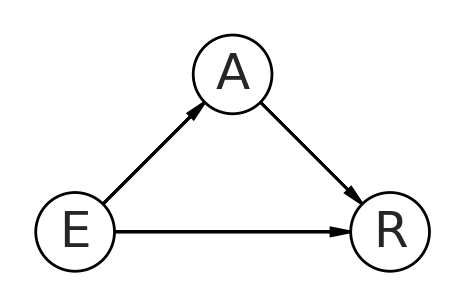

<IPython.core.display.Javascript object>

In [31]:
pipe_dag = CausalGraphicalModel(
    nodes=["E", "A", "R"],
    edges=[
        ("E", "A"),
        ("A", "R"),
        ("E", "R"),
    ],
)
pgm = daft.PGM()

coordinates = {
    "E": (0, 0),
    "A": (1, 1),
    "R": (2, 0),
}
for node in pipe_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in pipe_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()


/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


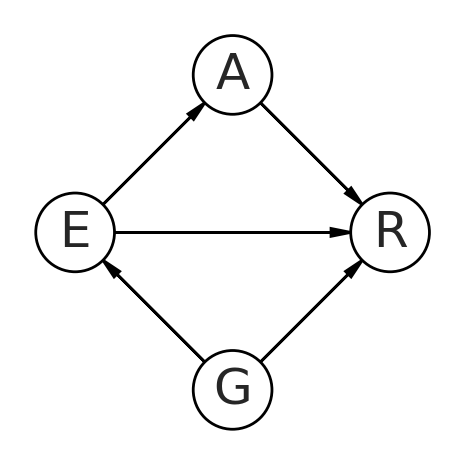

<IPython.core.display.Javascript object>

In [32]:
pipe_dag = CausalGraphicalModel(
    nodes=["E", "G", "A", "R"],
    edges=[
        ("E", "A"),
        ("A", "R"),
        ("E", "R"),
        ("G", "R"),
        ("G", "E"),
    ],
)
pgm = daft.PGM()

coordinates = {
    "E": (0, 0),
    "A": (1, 1),
    "R": (2, 0),
    "G": (1, -1),
}
for node in pipe_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in pipe_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()


**Update**

In terms of the paths of G to A, we now have the following:

- G > A (direct)
- G > D > A (D acts as a pipe)
- G > D < US > A (D acts as a collider)

Therefore, we're "hurt" by the fact that we can't answer our question with satisfaction since there are problems whether we condition on D or not.

McElreath's suggestion: "What can be done in these situations? The best thing is to stop analyzing convenient,
confounded data and instead design a real study."

In [37]:
np.array([[1, 2], [3, 4]])**2

array([[ 1,  4],
       [ 9, 16]])

<IPython.core.display.Javascript object>

Appendix: Environment and system parameters

In [33]:
%watermark -n -u -v -iv -w

Last updated: Fri Jul 02 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

pandas    : 1.2.1
matplotlib: 3.3.4
arviz     : 0.11.1
pymc3     : 3.11.0
daft      : 0.1.0
json      : 2.0.9
numpy     : 1.20.1
seaborn   : 0.11.1
scipy     : 1.6.0

Watermark: 2.1.0



<IPython.core.display.Javascript object>